In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
metrics_df = pd.read_csv('../data/processed/run_plays_12-3_0.csv')

In [18]:
metrics_df.iloc[19][['gameId', 'playId', 'frameId', 'x', 'y', 's', 'o', 'dir',
            'x_ball_carrier', 'y_ball_carrier', 's_ball_carrier', 
            'o_ball_carrier', 'dir_ball_carrier',
            'x_contact', 'y_contact', 'tackler_to_contact_dist']]

gameId                     2022090800
playId                            933
frameId                            50
x                               71.35
y                           24.173333
s                                 4.4
o                              284.53
dir                            249.97
x_ball_carrier                  70.52
y_ball_carrier              24.703333
s_ball_carrier                   3.14
o_ball_carrier                  94.84
dir_ball_carrier               254.73
x_contact                   79.613655
y_contact                   27.185959
tackler_to_contact_dist      8.795676
Name: 19, dtype: object

In [124]:
def plot_contact_point(x, y, dir_t, x_bc, y_bc, dir_bc, x_contact, y_contact):
    plt.plot([x, x_contact], [y, y_contact], color='red', linestyle='dashed',
         linewidth=2, markersize=12)
    plt.plot([x_bc, x_contact], [y_bc, y_contact], color='green', linestyle='dashed',
         linewidth=2, markersize=12)

    plt.plot(x, y, 'ro', markersize=12)
    plt.plot(x_bc, y_bc, 'go', markersize=12)
    plt.plot(x_contact, y_contact, 'X', color='black', markersize=14)
    
    r = 0.5
    
    x_arrow = r*np.cos(np.radians(90 - dir_t))
    y_arrow = r*np.sin(np.radians(90 - dir_t))
    plt.arrow(x, y, x_arrow, y_arrow, color='red', linewidth=2, head_width=0.2)
    
    x_arrow = r*np.cos(np.radians(90 - dir_bc))
    y_arrow = r*np.sin(np.radians(90 - dir_bc))
    plt.arrow(x_bc, y_bc, x_arrow, y_arrow, color='green', linewidth=2, head_width=0.2)
    
#     x_arrow = r*np.sin(np.radians(dir_bc))
#     y_arrow = r*np.cos(np.radians(dir_bc))
#     plt.arrow(x_bc, y_bc, x_arrow, y_arrow, color='black', linewidth=2, head_width=0.2)

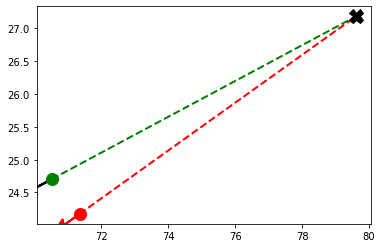

In [125]:
# defender
x = 71.35
y = 24.173333
dir_t = 249.97

# ball carrier
x_bc = 70.52
y_bc = 24.703333
dir_bc = 254.73

# contact point
x_contact = 79.613655
y_contact = 27.185959
plot_contact_point(x, y, dir_t, x_bc, y_bc, dir_bc, x_contact, y_contact)

In [126]:
def plot_contact_point_row(row):
    x = row['x']
    y = row['y']
    dir_t = row['dir']
    x_bc = row['x_ball_carrier']
    y_bc = row['y_ball_carrier']
    dir_bc = row['dir_ball_carrier']
    x_contact = row['x_contact']
    y_contact = row['y_contact']
    plot_contact_point(x, y, dir_t, x_bc, y_bc, dir_bc, x_contact, y_contact)

In [142]:
from scipy.spatial.distance import euclidean
metrics_df['bc_arrow_dist'] = metrics_df.apply(
                    lambda row: euclidean((row[f'x_ball_carrier'], row[f'y_ball_carrier']), 
                                          (row['x_ball_carrier'] + row[f'dir_sin_ball_carrier'], 
                                           row['y_ball_carrier'] + row[f'dir_cos_ball_carrier']))
                    , axis=1)

metrics_df['contact_bc_arrow_dist'] = metrics_df.apply(
                    lambda row: euclidean((row[f'x_contact'], row[f'y_contact']), 
                                          (row['x_ball_carrier'] + row[f'dir_sin_ball_carrier'], 
                                           row['y_ball_carrier'] + row[f'dir_cos_ball_carrier']))
                    , axis=1)

metrics_df['behind_ball_carrier'] = ((metrics_df['bc_arrow_dist'] < metrics_df['contact_bc_arrow_dist']) &
                                     (metrics_df['ball_carrier_to_contact_dist'] < metrics_df['contact_bc_arrow_dist']))

metrics_df['tackler_arrow_dist'] = metrics_df.apply(
                    lambda row: euclidean((row[f'x'], row[f'y']), 
                                          (row['x'] + row[f'dir_sin'], row['y'] + row[f'dir_cos']))
                    , axis=1)

metrics_df['contact_t_arrow_dist'] = metrics_df.apply(
                    lambda row: euclidean((row[f'x_contact'], row[f'y_contact']), 
                                          (row['x'] + row[f'dir_sin'], row['y'] + row[f'dir_cos']))
                    , axis=1)
    
metrics_df['behind_tackler'] = ((metrics_df['tackler_arrow_dist'] < metrics_df['contact_t_arrow_dist']) &
                                     (metrics_df['tackler_to_contact_dist'] < metrics_df['contact_t_arrow_dist']))

None
behind_ball_carrier    False
behind_tackler          True
Name: 10, dtype: object


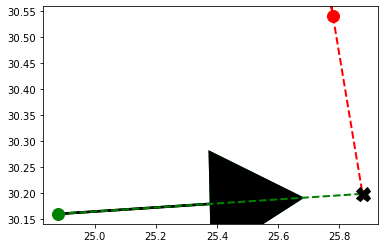

In [156]:
row = 10
print(metrics_df.iloc[row]['event'])
plot_contact_point_row(metrics_df.iloc[row])
print(metrics_df.iloc[row][['behind_ball_carrier', 'behind_tackler']])
# print(metrics_df.iloc[row][['bc_arrow_dist', 'contact_bc_arrow_dist', 'ball_carrier_to_contact_dist',
#                             'tackler_arrow_dist', 'contact_t_arrow_dist', 'tackler_to_contact_dist']])

In [157]:
metrics_df['behind_player'] = metrics_df['behind_ball_carrier'] | metrics_df['behind_tackler']

In [158]:
metrics_df[metrics_df['behind_player']][['event']].value_counts()

event           
None                3032
assist               817
tackle               780
pff_missedTackle     303
forcedFumble           3
dtype: int64

In [160]:
metrics_df[~metrics_df['behind_player']][['event']].value_counts()

event           
None                4853
tackle              3335
assist              2934
pff_missedTackle     530
dtype: int64

In [161]:
metrics_df[metrics_df['behind_tackler']][['event']].value_counts()

event           
None                1875
assist               478
tackle               371
pff_missedTackle     133
forcedFumble           3
dtype: int64

In [162]:
metrics_df[metrics_df['behind_ball_carrier']][['event']].value_counts()

event           
None                1686
tackle               483
assist               474
pff_missedTackle     183
forcedFumble           1
dtype: int64